<a href="https://colab.research.google.com/github/rahulvigneswaran/TailCalibX/blob/master/Notebooks/TailCalibX_Toy_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💻 Installation

In [1]:
!pip install tailcalib

# 👨‍💻 Basic Usage

In [2]:
# Import
from tailcalib import tailcalib

# Initialize
a = tailcalib(base_engine="numpy")   # Options: "numpy", "pytorch"

# Imbalanced random fake data
import numpy as np
X = np.random.rand(200,100)
y = np.random.randint(0,10, (200,))

# Balancing the data using "tailcalib"
feat, lab, gen = a.generate(X=X, y=y)

# Output comparison
print(f"Before: {np.unique(y, return_counts=True)}")
print(f"After: {np.unique(lab, return_counts=True)}")

100%|██████████| 10/10 [00:00<00:00, 39.78it/s]

Point Generation Completed!
Don't forget to use '.convert_others()' to apply tukey transformation on validation/test data before validation/testing. Use the same 'tukey_value' as the train data.

Before: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([23, 10, 23, 22, 22, 24, 23, 13, 19, 21]))
After: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24]))


## 🪀 Example with a Toy Dataset

100%|██████████| 2/2 [00:00<00:00, 777.08it/s]


Point Generation Completed!
Don't forget to use '.convert_others()' to apply tukey transformation on validation/test data before validation/testing. Use the same 'tukey_value' as the train data.



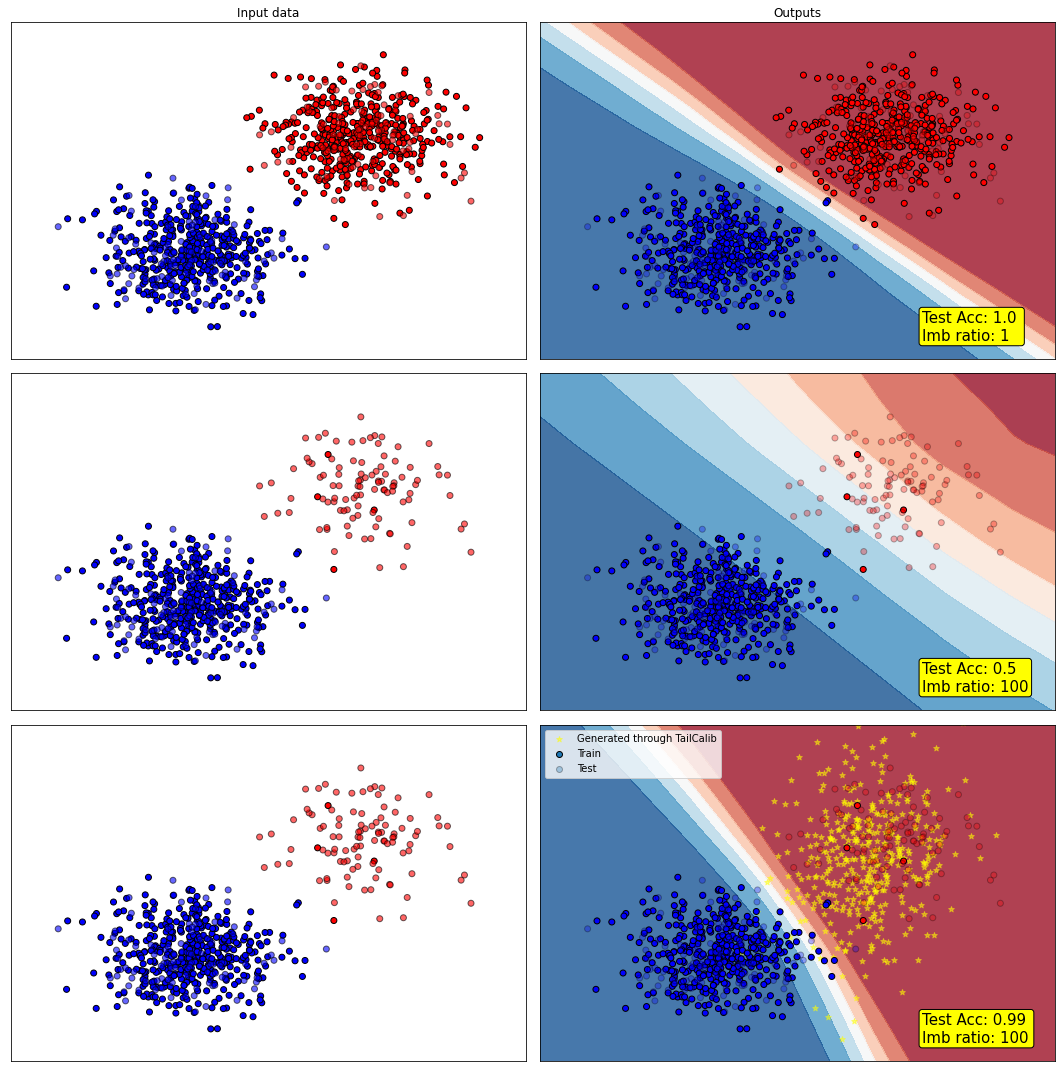

In [5]:
# Code source: Gaël Varoquaux
#              Andreas Müller
#              Jaques Grobler
# Modified by Rahul Vigneswaran
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from tailcalib import tailcalib

h = 0.02  # step size in the mesh

names = [
    "Neural Net",
]

classifiers = [
    MLPClassifier(alpha=0.7, max_iter=1000),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
centers = [[1, 1], [-1, -1]]
datasets = [
    (make_blobs(n_samples=1000, centers=centers, cluster_std=0.5, random_state=0),None, None,1),
    (make_blobs(n_samples=1000, centers=centers, cluster_std=0.5, random_state=0),"Original", 4, 100),
    (make_blobs(n_samples=1000, centers=centers, cluster_std=0.5, random_state=0),"TailCalib", 4, 100),
]

figure = plt.figure(figsize=(15, 15))
i = 1
# iterate over datasets
for ds_cnt, (ds, info, low_n, imb_r) in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    if low_n != None:
        n_low = low_n
        a = X_train[y_train == 0][:n_low]
        b = X_train[y_train == 1]
        X_train = np.concatenate((a,b))
        y_train = np.full(n_low, 0, dtype=int)
        y_b = np.full(len(b), 1, dtype=int)
        y_train = np.concatenate((y_train, y_b))
#-------TailCalib Usage------------------------------------------------------------------------------------------------
        if info == "TailCalib":
            a = tailcalib(base_engine="numpy") 
            X_train_new, y_train_new, gen = a.generate(X_train, y_train, tukey_value=1.0, alpha = 0.1, topk=1)
#----------------------------------------------------------------------------------------------------------------------
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if info == "TailCalib":
            clf.fit(X_train_new, y_train_new)
        else:
            clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        if info == "TailCalib":
            ax.scatter(
                gen[0][:, 0], gen[0][:, 1], c="yellow", marker="*", edgecolors="face", alpha=0.5, label="Generated through TailCalib"
            )

            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", label="Train"
            )

        else: 
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.3,
            label = "Test"
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title("Outputs")
        ax.text(
            xx.max() - 1.4,
            yy.min() + 0.3,
            (f"Test Acc: {score} \nImb ratio: {imb_r}"),
            # ("Test Accuracy: %.2f | Imbalance ratio: %.2f" % score % imb_r).lstrip("0"),
            size=15,
            horizontalalignment="left",
            bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.2'),
        )
        i += 1
        
ax.legend()
plt.tight_layout()
# plt.show()
plt.savefig("toy_example_output.svg", dpi=500)